#  <center> Taller  de Aprendizaje Automático </center>
##  <center> PROYECTO 1: BOSON DE HIGGS.  </center>
###  <center> Grupo C  </center>

In [1]:
from HiggsBosonCompetition_AMSMetric_rev1 import *

In [2]:
API_KEY = 'Del6g3JqhokU3s8y6z7RKnZzZ'

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier,StackingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
import optuna
import joblib
from comet_ml import Experiment


# General a todos los modelos:

In [4]:
test = pd.read_csv('test.csv')
train = pd.read_csv('training.csv')

X=train.drop(columns=['Label'])
y=(train['Label'] == 's').astype(int)

X_train, X_val, y_train, y_val= train_test_split(X, y,test_size=0.2,stratify=y,random_state=42)
pesos_val=X_val['Weight']

In [5]:
def fun_add_column(X):
    X = X.copy()
    X["topology"] = np.where(X['DER_mass_MMC'] == -999, 0, 1)
    return X

agrego_topology = FunctionTransformer(fun_add_column)

features_999 = ["PRI_jet_leading_pt", "PRI_jet_leading_eta", "PRI_jet_leading_phi","DER_deltaeta_jet_jet", "DER_mass_jet_jet", "DER_prodeta_jet_jet",
    "DER_lep_eta_centrality", "PRI_jet_subleading_pt","PRI_jet_subleading_eta", "PRI_jet_subleading_phi",'DER_mass_MMC']

def drop_eventid_weight(X):
    return X.drop(columns=["EventId", "Weight"], errors="ignore")

drop_columns = FunctionTransformer(drop_eventid_weight)


In [6]:
def umbral_optimo_con_return(modelo,pesos_val,X_val,y_val):
    pesos_val_mod = pesos_val.reset_index(drop=True).to_numpy()
    y_val_mod = y_val.reset_index(drop=True).to_numpy()
    pred_proba_val = modelo.predict_proba(X_val)[:, 1]

    scores = []
    for t in np.linspace(0.2, 0.9, 500):
        y_pred = (pred_proba_val > t).astype(int)
        s = pesos_val_mod[(y_pred == 1) & (y_val_mod == 1)].sum()
        b = pesos_val_mod[(y_pred == 1) & (y_val_mod == 0)].sum()
        ams = AMS(s, b)
        scores.append((ams, t))
    
    ams_values, t_values = zip(*scores)
    
    best_ams, best_threshold = max(scores, key=lambda x: x[0])
    print(f" Mejor AMS: {best_ams:.4f} con umbral = {best_threshold:.4f}")
    
    plt.plot(t_values, ams_values, label='AMS vs. t')
    plt.axvline(x=best_threshold, color='r', linestyle='--', label=f"Mejor umbral = {best_threshold:.4f}")
    plt.xlabel('Umbral')
    plt.ylabel('AMS')
    plt.title('Umbral vs AMS')
    plt.legend()
    plt.show()
    
    return best_ams, best_threshold, pred_proba_val

In [32]:
def umbral_optimo_con_return_red(modelo,pesos_val,X_val,y_val):
    pesos_val_mod = pesos_val.reset_index(drop=True).to_numpy()
    y_val_mod = y_val.reset_index(drop=True).to_numpy()
    pred_proba_val = modelo.predict(X_val).flatten()

    scores = []
    for t in np.linspace(0.2, 0.9, 500):
        y_pred = (pred_proba_val > t).astype(int)
        s = pesos_val_mod[(y_pred == 1) & (y_val_mod == 1)].sum()
        b = pesos_val_mod[(y_pred == 1) & (y_val_mod == 0)].sum()
        ams = AMS(s, b)
        scores.append((ams, t))
    
    ams_values, t_values = zip(*scores)
    
    best_ams, best_threshold = max(scores, key=lambda x: x[0])
    print(f" Mejor AMS: {best_ams:.4f} con umbral = {best_threshold:.4f}")
    
    plt.plot(t_values, ams_values, label='AMS vs. t')
    plt.axvline(x=best_threshold, color='r', linestyle='--', label=f"Mejor umbral = {best_threshold:.4f}")
    plt.xlabel('Umbral')
    plt.ylabel('AMS')
    plt.title('Umbral vs AMS')
    plt.legend()
    plt.show()
    
    return best_ams, best_threshold, pred_proba_val

In [7]:
def umbral_optimo_con_return_probas(a,b,c,d,proba_xgb,proba_lgbm,proba_rf,proba_red,pesos_val,y_val):
    '''
    a: peso de proba_xgb
    b: peso de proba_lgbm
    c: peso de proba_rf
    d: peso de proba_red
    '''
    probas_combinadas = a * proba_xgb + b*proba_lgbm + c*proba_rf + d*proba_red
    pesos_val_mod = pesos_val.reset_index(drop=True).to_numpy()
    y_val_mod = y_val.reset_index(drop=True).to_numpy()

    scores = []
    for t in np.linspace(0.2, 0.9, 500):
        y_pred = (probas_combinadas > t).astype(int)
        s = pesos_val_mod[(y_pred == 1) & (y_val_mod == 1)].sum()
        b = pesos_val_mod[(y_pred == 1) & (y_val_mod == 0)].sum()
        ams = AMS(s, b)
        scores.append((ams, t))
    
    ams_values, t_values = zip(*scores)
    
    best_ams, best_threshold = max(scores, key=lambda x: x[0])
    print(f" Mejor AMS: {best_ams:.4f} con umbral = {best_threshold:.4f}")
    
    plt.plot(t_values, ams_values, label='AMS vs. t')
    plt.axvline(x=best_threshold, color='r', linestyle='--', label=f"Mejor umbral = {best_threshold:.4f}")
    plt.xlabel('Umbral')
    plt.ylabel('AMS')
    plt.title('Umbral vs AMS')
    plt.legend()
    plt.show()
    
    return best_ams, best_threshold, probas_combinadas

# RF

In [8]:
PRI = ['PRI_tau_pt',
 'PRI_tau_eta',
 'PRI_tau_phi',
 'PRI_lep_pt',
 'PRI_lep_eta',
 'PRI_lep_phi',
 'PRI_met',
 'PRI_met_phi',
 'PRI_met_sumet',
 'PRI_jet_num',
 'PRI_jet_leading_pt',
 'PRI_jet_leading_eta',
 'PRI_jet_leading_phi',
 'PRI_jet_subleading_pt',
 'PRI_jet_subleading_eta',
 'PRI_jet_subleading_phi',
 'PRI_jet_all_pt']
DER = ['DER_mass_MMC',
 'DER_mass_transverse_met_lep',
 'DER_mass_vis',
 'DER_pt_h',
 'DER_deltaeta_jet_jet',
 'DER_mass_jet_jet',
 'DER_prodeta_jet_jet',
 'DER_deltar_tau_lep',
 'DER_pt_tot',
 'DER_sum_pt',
 'DER_pt_ratio_lep_tau',
 'DER_met_phi_centrality',
 'DER_lep_eta_centrality']

DER_imputer = SimpleImputer(missing_values=-999,strategy='median')
PRI_imputer = SimpleImputer(missing_values=-999,strategy='constant', fill_value=0)

procesamiento_DER = Pipeline([
        ("imputacionDER", DER_imputer),
        ("Scaler", StandardScaler() )])

procesamiento_PRI_0 = Pipeline([
        ("imputacionPRI", PRI_imputer),
        ("Scaler", StandardScaler() )])

preprocesador_0_ohe = ColumnTransformer([
      ("ohe", OneHotEncoder(sparse_output=False, handle_unknown="ignore"),["PRI_jet_num"]),
      ('DER_imputer', procesamiento_DER, DER),
      ('PRI_imputer', procesamiento_PRI_0, PRI)
  ], remainder='drop') 

pipeline_rf  = Pipeline([
    ('preprocesamiento', preprocesador_0_ohe),
    # ('pca', PCA(n_components=0.99)),
    ('clasificador', RandomForestClassifier(random_state=42,max_depth=50,min_samples_leaf=2,min_samples_split=5,n_estimators=700,n_jobs=-1))
    ])

In [9]:
# cargamos el modelo ya fiteado -> pipeline_rf.fit(X_train,y_train)
pipeline_rf = joblib.load("mejor_RF.pkl")

In [10]:
pipeline_rf 

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['PRI_jet_num']),
                                                 ('DER_imputer',
                                                  Pipeline(steps=[('imputacionDER',
                                                                   SimpleImputer(missing_values=-999,
                                                                                 strategy='median')),
                                                                  ('Scaler',
                                                                   StandardScaler())]),
                                                  ['DER_mass_MMC',
                                                   'DER_mass_transverse_met_lep',
                                                   'DER_mass_vis', 'DER_p...
                                                   'PRI_met', 'PRI_met_phi',
                                                   'PRI_met_sumet',
                                                   'PRI_jet_num',
                                                   'PRI_jet_leading_pt',
                                                   'PRI_jet_leading_eta',
                                                   'PRI_jet_leading_phi',
                                                   'PRI_jet_subleading_pt',
                                                   'PRI_jet_subleading_eta',
                                                   'PRI_jet_subleading_phi',
                                                   'PRI_jet_all_pt'])])),
                ('clasificador',
                 RandomForestClassifier(max_depth=50, min_samples_leaf=2,
                                        min_samples_split=5, n_estimators=700,
                                        n_jobs=-1, random_state=42))])

In [11]:
# descomentar para ver los pasos del pipeline
# pipeline_rf.steps

 Mejor AMS: 1.5415 con umbral = 0.7373


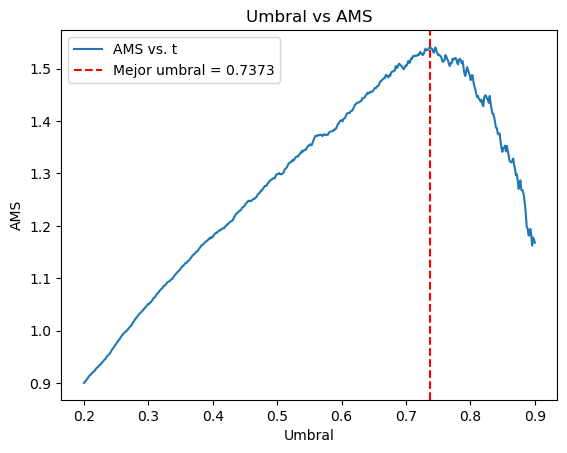

In [12]:
best_ams_rf , best_threshold_rf, pred_proba_val_rf = umbral_optimo_con_return(pipeline_rf,pesos_val,X_val,y_val)

## Experimento a comet

In [13]:
exp1 = Experiment(api_key=API_KEY, project_name="proyecto-1-FINALES", workspace="ury16")
exp1.set_name('Rf')
exp1.add_tags(['RF', 'PRI=0', 'full-features','ohe'])

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, lightgbm, tensorflow, keras, xgboost.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ury16/proyecto-1-finales/8f21d9e005884d0788d9ab51bb7ab8af

COMET INFO: Couldn't find a Git repository in 'c:\\Users\\Magdalena\\Desktop\\FING\\2025\\TAA\\Proyecto 1\\Entrega_grupo_C' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


In [14]:
# metrica
exp1.log_metrics({
    'AMS': best_ams_rf,
})

#  parametros
exp1.log_parameters({
    'threshold': best_threshold_rf,
    'model': 'RandomForestClassifier',
    'n_estimators': 700,
    'max_depth': 50,
    'min_samples_leaf': 2,
    'min_samples_split': 5,
    'PRI_imputation_strategy': 'constant',
    'PRI_imputation_value': 0,
    'DER_imputation_strategy': 'median',
})

exp1.end()

COMET INFO: The process of logging environment details (conda environment, git patch) is underway. Please be patient as this may take some time.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Rf
COMET INFO:     url                   : https://www.comet.com/ury16/proyecto-1-finales/8f21d9e005884d0788d9ab51bb7ab8af
COMET INFO:   Metrics:
COMET INFO:     AMS : 1.5415048859023588
COMET INFO:   Others:
COMET INFO:     Name : Rf
COMET INFO:   Parameters:
COMET INFO:     DER_imputation_strategy : median
COMET INFO:     PRI_imputation_strategy : constant
COMET INFO:     PRI_imputation_value    : 0
COMET INFO:     max_depth               : 50
COMET INFO:     min_samples_leaf        : 2
COMET INFO:     min

# XGB

In [15]:
pipeline_xgb_ohe = Pipeline([
    ("drop_columns", drop_columns),
    ("agrego_topology", agrego_topology),
    ("imputer", ColumnTransformer(
        transformers=[
            ("ohe", OneHotEncoder(sparse_output=False, handle_unknown="ignore"),["PRI_jet_num"]),
            ("imputer", SimpleImputer(missing_values=-999, strategy="constant",fill_value=np.nan), features_999)], 
        remainder="passthrough")),  
    ("xgb", XGBClassifier(n_estimators=400,learning_rate=0.05,subsample=0.8,max_depth=7,eval_metric="auc",tree_method='hist',gamma=0,colsample_bytree=0.8,random_state=42))
])

In [16]:
# cargamos el modelo ya fiteado -> pipeline_xgb_ohe.fit(X_train,y_train)
pipeline_xgb = joblib.load("mejor_XGB.pkl")

In [17]:
pipeline_xgb

Pipeline(steps=[('drop_columns',
                 FunctionTransformer(func=<function drop_eventid_weight at 0x0000019928CC3C40>)),
                ('agrego_topology',
                 FunctionTransformer(func=<function fun_add_column at 0x0000019928CC2A20>)),
                ('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['PRI_jet_num']),...
                               feature_types=None, feature_weights=None,
                               gamma=0, grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=400, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [18]:
# descomentar para ver los pasos del pipeline
# pipeline_xgb.steps

 Mejor AMS: 1.5738 con umbral = 0.8313


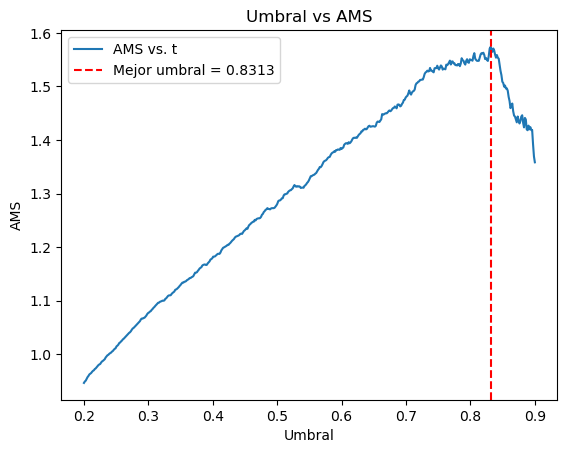

In [19]:
best_ams_xgb , best_threshold_xgb, pred_proba_val_xgb = umbral_optimo_con_return(pipeline_xgb,pesos_val,X_val,y_val)

## Experimento a comet

In [20]:
exp2 = Experiment(api_key=API_KEY, project_name="proyecto-1-FINALES", workspace="ury16")
exp2.set_name('Xgb')
exp2.add_tags(['Xgb', 'Nan', 'full-features', 'ohe', 'tpology'])

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, lightgbm, tensorflow, keras, xgboost.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ury16/proyecto-1-finales/fd1194c64d114320aa06af84fff2446d

COMET INFO: Couldn't find a Git repository in 'c:\\Users\\Magdalena\\Desktop\\FING\\2025\\TAA\\Proyecto 1\\Entrega_grupo_C' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


In [21]:
# metrica
exp2.log_metrics({
    'AMS': best_ams_xgb,
})

#  parametros
exp2.log_parameters({
    'threshold': best_threshold_xgb,
    'model': 'XGBClassifier',
    'n_estimators': 400,
    'max_depth': 7,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'eval_metric': "auc",
    'tree_method': 'hist',
    'gamma': 0,
    'colsample_bytree': 0.8,
    'imputation_strategy': 'constant',
    'imputation_value': 'Nan',
})

exp2.end()

COMET INFO: The process of logging environment details (conda environment, git patch) is underway. Please be patient as this may take some time.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Xgb
COMET INFO:     url                   : https://www.comet.com/ury16/proyecto-1-finales/fd1194c64d114320aa06af84fff2446d
COMET INFO:   Metrics:
COMET INFO:     AMS : 1.5738221576304345
COMET INFO:   Others:
COMET INFO:     Name : Xgb
COMET INFO:   Parameters:
COMET INFO:     colsample_bytree    : 0.8
COMET INFO:     eval_metric         : auc
COMET INFO:     gamma               : 0
COMET INFO:     imputation_strategy : constant
COMET INFO:     imputation_value    : Nan
COMET INFO:     learning_rate       :

# LGBM

In [22]:
pipeline_lgbm = Pipeline([
    ("drop_columns", drop_columns),
    ("agrego_topology", agrego_topology),
    ("imputer", ColumnTransformer(
        transformers=[
            ("ohe", OneHotEncoder(sparse_output=False, handle_unknown="ignore"),["PRI_jet_num"]),
            ("imputer", SimpleImputer(missing_values=-999, strategy="constant",fill_value=np.nan), features_999)], 
        remainder="passthrough")),  
    ("clf", LGBMClassifier(n_estimators=600,max_depth=10,learning_rate=0.05,random_state=42))
])

In [23]:
# cargamos el modelo ya fiteado -> pipeline_lgbm.fit(X_train,y_train)
pipeline_lgbm = joblib.load("mejor_LGBM.pkl")

In [24]:
pipeline_lgbm

Pipeline(steps=[('drop_columns',
                 FunctionTransformer(func=<function drop_eventid_weight at 0x0000019928CC3C40>)),
                ('agrego_topology',
                 FunctionTransformer(func=<function fun_add_column at 0x0000019928CC2A20>)),
                ('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['PRI_jet_num']),...
                                                                strategy='constant'),
                                                  ['PRI_jet_leading_pt',
                                                   'PRI_jet_leading_eta',
                                                   'PRI_jet_leading_phi',
                                                   'DER_deltaeta_jet_jet',
                                                   'DER_mass_jet_jet',
                                                   'DER_prodeta_jet_jet',
                                                   'DER_lep_eta_centrality',
                                                   'PRI_jet_subleading_pt',
                                                   'PRI_jet_subleading_eta',
                                                   'PRI_jet_subleading_phi',
                                                   'DER_mass_MMC'])])),
                ('clf',
                 LGBMClassifier(learning_rate=0.05, max_depth=10,
                                n_estimators=600, random_state=42))])

In [25]:
# pipeline_lgbm.steps

 Mejor AMS: 1.5679 con umbral = 0.8327


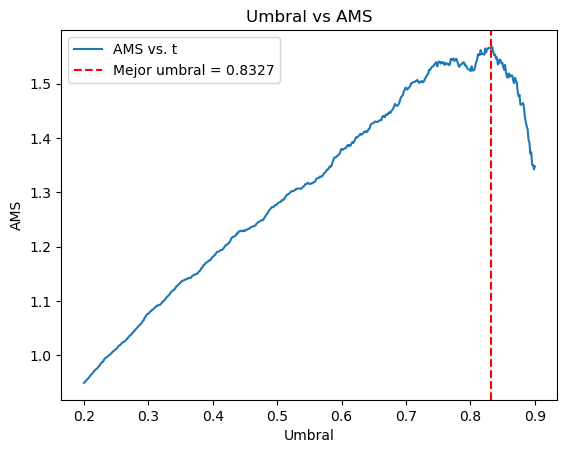

In [26]:
best_ams_lgbm , best_threshold_lgbm, pred_proba_val_lgbm = umbral_optimo_con_return(pipeline_lgbm,pesos_val,X_val,y_val) 

## Experimento a comet

In [27]:
exp3 = Experiment(api_key=API_KEY, project_name="proyecto-1-FINALES", workspace="ury16")
exp3.set_name('Lgbm')
exp3.add_tags(['Lgbm', 'Nan', 'full-features', 'ohe', 'tpology'])

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, lightgbm, tensorflow, keras, xgboost.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ury16/proyecto-1-finales/0faa7982a51c496abda86f7db069b9b6

COMET INFO: Couldn't find a Git repository in 'c:\\Users\\Magdalena\\Desktop\\FING\\2025\\TAA\\Proyecto 1\\Entrega_grupo_C' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


In [28]:
# metrica
exp3.log_metrics({
    'AMS': best_ams_lgbm,
})

#  parametros
exp3.log_parameters({
    'threshold': best_threshold_lgbm,
    'model': 'LGBMClassifier',
    'n_estimators': 600,
    'max_depth': 10,
    'learning_rate': 0.05,
    'imputation_strategy': 'constant',
    'imputation_value': 'Nan',
})

exp3.end()

COMET INFO: The process of logging environment details (conda environment, git patch) is underway. Please be patient as this may take some time.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Lgbm
COMET INFO:     url                   : https://www.comet.com/ury16/proyecto-1-finales/0faa7982a51c496abda86f7db069b9b6
COMET INFO:   Metrics:
COMET INFO:     AMS : 1.5679452731679262
COMET INFO:   Others:
COMET INFO:     Name : Lgbm
COMET INFO:   Parameters:
COMET INFO:     imputation_strategy : constant
COMET INFO:     imputation_value    : Nan
COMET INFO:     learning_rate       : 0.05
COMET INFO:     max_depth           : 10
COMET INFO:     model               : LGBMClassifier
COMET INFO:     n_esti

# RED

In [40]:
num_cols = (train.drop(columns=['Weight', 'Label', 'EventId', 'PRI_jet_num'])).columns.to_list()
cat_cols = ['PRI_jet_num']

def add_missing_indicators(df):
    df = df.copy()
    for col in df.columns:
        if (df[col] == -999).any():
            df[col + '_missing'] = (df[col] == -999).astype(int)
    return df

base_pipeline = Pipeline([
    ("drop_columns", FunctionTransformer(lambda X: X.drop(columns=["EventId", "Weight"], errors="ignore"))),
    ("add_missing_indicators", FunctionTransformer(add_missing_indicators, validate=False)),
])

preprocessing = ColumnTransformer([
    ("scale_numeric", StandardScaler(), num_cols),             
    ("onehot_categorical", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)  
], remainder='passthrough')  

full_pipeline = Pipeline([
    ("preprocess", base_pipeline),
    ("transform", preprocessing),
])

In [41]:
tf.random.set_seed(42)

model_red = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(44,)),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=6, restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    factor=0.5, patience=3, verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras", save_best_only=True
)

model_red.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(name="roc_auc")]
)

X_train_p = full_pipeline.fit_transform(X_train)
X_val_p = full_pipeline.transform(X_val)

# history = model_red.fit(
#     X_train_p, y_train,
#     validation_data=(X_val_p, y_val),
#     epochs=500, 
#     callbacks=[early_stopping, reduce_lr, checkpoint]
# )

In [42]:
model_red = load_model("best_model.keras")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 648us/step
 Mejor AMS: 1.5390 con umbral = 0.8271


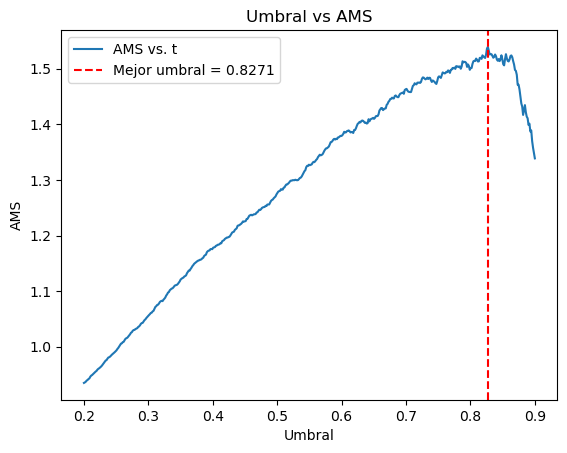

In [43]:
best_ams_red , best_threshold_red, pred_proba_val_red = umbral_optimo_con_return_red(model_red,pesos_val,X_val_p,y_val) 

## Experimento a comet

In [44]:
exp4 =  Experiment(api_key=API_KEY, project_name="proyecto-1-FINALES", workspace="ury16")
exp4.set_name('Red')
exp4.add_tags(['Red', 'Nan', 'full-features', 'ohe', 'tpology'])

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, lightgbm, tensorflow, keras, xgboost.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Red
COMET INFO:     url                   : https://www.comet.com/ury16/proyecto-1-finales/b0b633e6dca34740a3cba430bf50f000
COMET INFO:   Metrics:
COMET INFO:     AMS : 1.5389677854531516
COMET INFO:   Others:
COMET INFO:     Name : Red
COMET INFO:   Parameters:
COMET INFO:     dropout_1               : 0.3
COMET INFO:     early_stopping_patience : 6
COMET INFO:     epochs                  : 500
COMET INFO:     features_used           : 44
COMET INFO:     imputation_strategy     : constant
COMET INFO:     i

In [ ]:
# metrica
exp4.log_metrics({
    'AMS': best_ams_red,
})

#  parametros
exp4.log_parameters({
    'threshold': best_threshold_red,
    'model': 'KerasSequential',
    'input_shape': 44,
    'layer_1': 'Dense(300, relu)',
    'dropout_1': 0.3,
    'layer_2': 'Dense(300, relu)',
    'output': 'Dense(1, sigmoid)',
    'learning_rate': 1e-4,
    'optimizer': 'Adam',
    'loss': 'binary_crossentropy',
    'metric': 'AUC',
    'epochs': 500,
    'early_stopping_patience': 6,
    'reduce_lr_patience': 3,
    'reduce_lr_factor': 0.5,
    'imputation_strategy': 'constant',
    'imputation_value': -999,
    'features_used': 44,
})

# Pruebas con probabilidades diferentes para la ponderación de los modelos

##  a = b = c = d = 1/4 -> mismo peso a todos

 Mejor AMS: 1.5975 con umbral = 0.8228


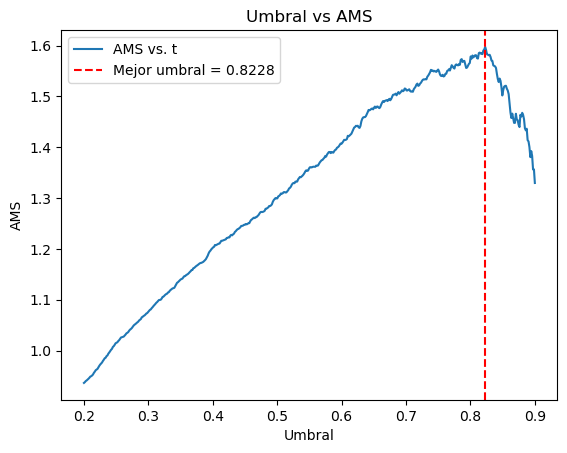

In [46]:
a = b = c = d = 1/4

best_ams_1 , best_threshold_1, pred_proba_val_1 = umbral_optimo_con_return_probas(a,b,c,d,
                                                            pred_proba_val_xgb,pred_proba_val_lgbm,pred_proba_val_rf,pred_proba_val_red,
                                                            pesos_val,y_val)

## a = b = c = 2/15 y d = 3/5  -> mas peso a la red arboles mismo peso

 Mejor AMS: 1.6006 con umbral = 0.8242


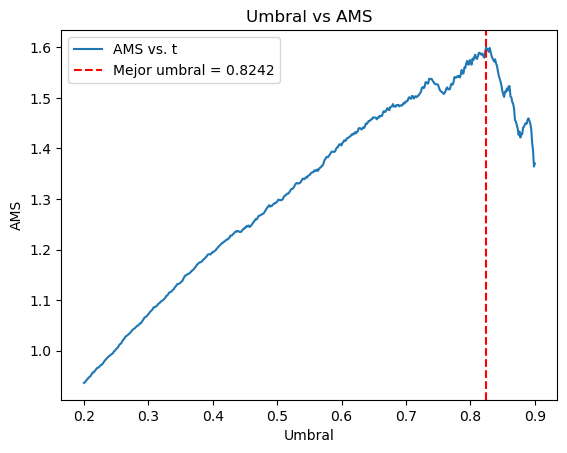

In [47]:
a = b = c = 2/15
d = 3/5

best_ams_2 , best_threshold_2, pred_proba_val_2 = umbral_optimo_con_return_probas(a,b,c,d,
                                                            pred_proba_val_xgb,pred_proba_val_lgbm,pred_proba_val_rf,pred_proba_val_red,
                                                            pesos_val,y_val)

## a = 2/5  b = 1/5  c = 2/5  d = 1/5 -> mas peso al xgb

 Mejor AMS: 1.5955 con umbral = 0.8172


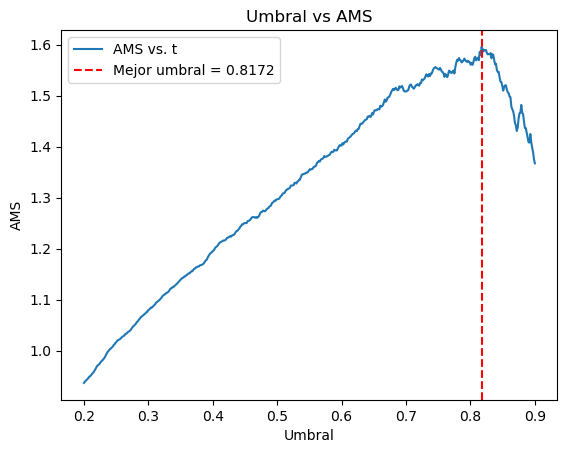

In [48]:
a = 2/5
b = 1/5
c = 1/5
d = 1/5

best_ams_3 , best_threshold_3, pred_proba_val_3 = umbral_optimo_con_return_probas(a,b,c,d,
                                                            pred_proba_val_xgb,pred_proba_val_lgbm,pred_proba_val_rf,pred_proba_val_red,
                                                            pesos_val,y_val)

## Optuna

In [59]:
###################
# SE DEJA COMENTADO PORQUE SI SE VUELVE A CORRER GENERA OTROS VALORES
###################


# def objective(trial):
#     a = trial.suggest_float('a', 0, 1)
#     b = trial.suggest_float('b', 0, 1 - a)
#     c = trial.suggest_float('c', 0, 1 - a - b)
#     d = 1 - a - b - c

#     probas_combinadas = (
#         a * pred_proba_val_xgb +
#         b * pred_proba_val_lgbm +
#         c * pred_proba_val_rf +
#         d * pred_proba_val_red
#     )

#     pesos_val_mod = pesos_val.reset_index(drop=True).to_numpy()
#     y_val_mod = y_val.reset_index(drop=True).to_numpy()

    
#     best_ams = 0
#     for t in np.linspace(0.2, 0.9, 200):
#         y_pred = (probas_combinadas > t).astype(int)
#         s = pesos_val_mod[(y_pred.flatten() == 1) & (y_val_mod == 1)].sum()
#         b = pesos_val_mod[(y_pred.flatten() == 1) & (y_val_mod == 0)].sum()
#         ams = AMS(s, b)
#         if ams > best_ams:
#             best_ams = ams

#     return best_ams


# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)


# print("Mejor AMS:", study.best_value)
# print("Mejores pesos encontrados:", study.best_params)

 Mejor AMS: 1.6032 con umbral = 0.8271


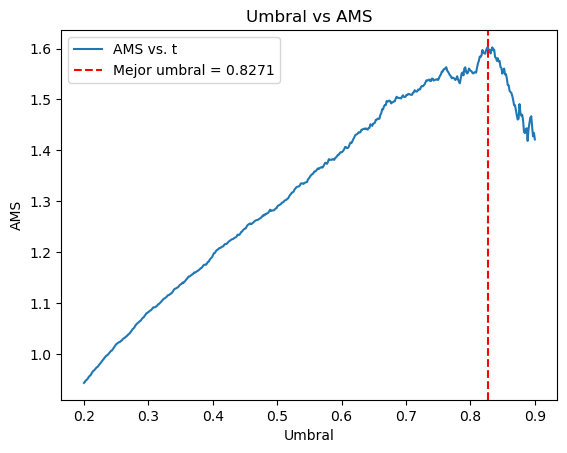

In [50]:
a = 0.4784642696512927
b = 0.2468932190609368
c = 0.027155806847942998
d = 1 - a - b - c

best_ams_3 , best_threshold_3, pred_proba_val_3 = umbral_optimo_con_return_probas(a,b,c,d,
                                                            pred_proba_val_xgb,pred_proba_val_lgbm,pred_proba_val_rf,pred_proba_val_red,
                                                            pesos_val,y_val)

# Modelo final

In [51]:
a = 0.4784642696512927
b = 0.2468932190609368
c = 0.027155806847942998
d = 1 - a - b - c

In [52]:
#SUBMISSION DEL MODELO FINAL

X_test_kaggle = test 
ids_test2 = test['EventId']

xgb_test = pipeline_xgb.fit(X,y)
lgbm_test = pipeline_lgbm.fit(X,y)
rf_test = pipeline_rf.fit(X,y)

[LightGBM] [Info] Number of positive: 85667, number of negative: 164333
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342668 -> initscore=-0.651427
[LightGBM] [Info] Start training from score -0.651427


In [53]:
proba_xgb_test = xgb_test.predict_proba(X_test_kaggle)[:, 1]
proba_lgbm_test = lgbm_test.predict_proba(X_test_kaggle)[:, 1]
proba_rf_test = rf_test.predict_proba(X_test_kaggle)[:, 1]
X_test_kaggle_p=full_pipeline.transform(X_test_kaggle)
proba_red_test = model_red.predict(X_test_kaggle_p).flatten()


y_proba_final = a * proba_xgb_test + b*proba_lgbm_test + c*proba_rf_test + d*proba_red_test


y_score = (y_proba_final > best_threshold_3)


submission = pd.DataFrame()
submission['EventId'] = ids_test2
submission['Class'] = ['s' if y else 'b' for y in y_score]
submission['proba'] = y_proba_final
submission = submission.sort_values('proba', ascending=False)
submission['RankOrder'] = np.arange(1, len(submission) + 1)
submission = submission[['EventId', 'RankOrder', 'Class']]
submission.to_csv("submissionTest_full.csv", index=False)

17188/17188 ━━━━━━━━━━━━━━━━━━━━ 12s 680us/step


## Experimento a comet

In [56]:
exp5 = Experiment(api_key=API_KEY, project_name='proyecto-1-FINALES', workspace='ury16')
exp5.set_name('Modelo Combinado Final')
exp5.add_tags(['Ensemble', 'Optuna', 'AMS-opt', 'modelo-final'])

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, lightgbm, tensorflow, keras, xgboost.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Modelo Combinado Final
COMET INFO:     url                   : https://www.comet.com/ury16/proyecto-1-finales/80570f01f025448790cbbaf9f309d8f0
COMET INFO:   Others:
COMET INFO:     Name : Modelo Combinado Final
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     installed package

In [57]:
#  metrica
exp5.log_metrics({
    'AMS': best_ams_3
})


#  parametros
exp5.log_parameters({
    'model': 'Ensamble',
    'base_models': 'xgb, lgbm, rf, red',
    'optimizacion': 'Optuna',
    'peso_xgb': a,
    'peso_lgbm': b,
    'peso_rf': c,
    'peso_red': d,
    'threshold': best_threshold_3,
    'n_trials': 100,
    'threshold_search_range': '[0.2, 0.9]',
    'threshold_steps': 200,
})